<a href="https://colab.research.google.com/github/kalopez0621/Portfolio/blob/main/Natural%20Language%20Processing%20Projects%20/%20RecommendationEngine_GoodBooksReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Setting Up the Environment

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
# URLs for each dataset
books_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/refs/heads/master/books.csv"
book_tags_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/refs/heads/master/book_tags.csv"
tags_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/refs/heads/master/tags.csv"
ratings_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/refs/heads/master/ratings.csv"

# Load datasets
books_df = pd.read_csv(books_url)
book_tags_df = pd.read_csv(book_tags_url)
tags_df = pd.read_csv(tags_url)
ratings_df = pd.read_csv(ratings_url)

# Display loaded data for verification
print("Books Data:", books_df.head())
print("Book Tags Data:", book_tags_df.head())
print("Tags Data:", tags_df.head())
print("Ratings Data:", ratings_df.head())

Books Data:    book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings

# Step 2: Exploring and Preprocessing the Dataset

Generate Enriched Book Descriptions

In [ ]:
# Merge `book_tags_df` with `tags_df` to get tag names
book_tags_df = book_tags_df.merge(tags_df, on='tag_id', how='left')

# Select top tags for each book and combine them
top_tags_df = (
    book_tags_df.sort_values(by=['goodreads_book_id', 'count'], ascending=[True, False])
    .groupby('goodreads_book_id')
    .head(5)
    .groupby('goodreads_book_id')['tag_name']
    .apply(lambda tags: ' '.join(tags))
    .reset_index()
)

# Merge top tags with book information
books_with_tags_df = books_df.merge(top_tags_df, left_on='goodreads_book_id', right_on='goodreads_book_id', how='left')
books_with_tags_df['tag_name'] = books_with_tags_df['tag_name'].fillna('')

# Combine title, authors, and tags into a single description field
books_with_tags_df['description_enriched'] = (
    books_with_tags_df['title'] + ' ' + books_with_tags_df['authors'] + ' ' + books_with_tags_df['tag_name']
)

# Handle missing values in 'description_enriched'
books_with_tags_df['description_enriched'] = books_with_tags_df['description_enriched'].fillna('')


Integrate Average Ratings

In [ ]:
# Step 3: Integrate Average Ratings

# Calculate average rating and ratings count for each book
ratings_summary = (
    ratings_df.groupby('book_id')['rating']
    .agg(average_rating='mean', ratings_count='count')
    .reset_index()
)

# Drop any existing average_rating and ratings_count columns in books_with_tags_df
books_with_tags_df = books_with_tags_df.drop(columns=['average_rating_x', 'ratings_count_x', 'average_rating_y', 'ratings_count_y', 'average_rating', 'ratings_count'], errors='ignore')

# Display columns in books_with_tags_df before merge to confirm removal
print("Columns in books_with_tags_df after dropping duplicates:", books_with_tags_df.columns)

# Merge the average ratings and counts from ratings_summary into books_with_tags_df
books_with_tags_df = books_with_tags_df.merge(ratings_summary, on='book_id', how='left')

# Fill NaN ratings and counts if any books have no ratings
books_with_tags_df['average_rating'] = books_with_tags_df['average_rating'].fillna(0)
books_with_tags_df['ratings_count'] = books_with_tags_df['ratings_count'].fillna(0).astype(int)

# Display columns after merging to confirm everything is correct
print("Columns after merge:", books_with_tags_df.columns)

# Display sample data to verify
print("\nSample data:\n", books_with_tags_df[['title', 'authors', 'average_rating', 'ratings_count']].head())


Columns in books_with_tags_df after dropping duplicates: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url', 'tag_name',
       'description_enriched'],
      dtype='object')
Columns after merge: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url', 'tag_name',
       'description_enriched', 'average_rating', 'ratings_count'],
      dtype='object')

Sample data:
                           

In [ ]:
# Fill missing values in 'description_enriched' with an empty string
books_with_tags_df['description_enriched'] = books_with_tags_df['description_enriched'].fillna('')

# Display the first 5 rows of the 'description_enriched' column
print(books_with_tags_df['description_enriched'].head())


0    The Hunger Games (The Hunger Games, #1) Suzann...
1    Harry Potter and the Sorcerer's Stone (Harry P...
2    Twilight (Twilight, #1) Stephenie Meyer young-...
3    To Kill a Mockingbird Harper Lee classics favo...
4    The Great Gatsby F. Scott Fitzgerald classics ...
Name: description_enriched, dtype: object


# Step 3: Text Preprocessing and Tokenization

In [ ]:
# Download necessary NLTK data files
nltk.download('words')

# Set of English words for filtering
english_words = set(words.words())

# Display the first 5 rows of the 'description_enriched' column
print(books_with_tags_df['description_enriched'].head())

0    The Hunger Games (The Hunger Games, #1) Suzann...
1    Harry Potter and the Sorcerer's Stone (Harry P...
2    Twilight (Twilight, #1) Stephenie Meyer young-...
3    To Kill a Mockingbird Harper Lee classics favo...
4    The Great Gatsby F. Scott Fitzgerald classics ...
Name: description_enriched, dtype: object


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Define the text preprocessing function
def preprocess_text(text):
    # Convert to string if it's not already
    if not isinstance(text, str):
        text = str(text)

    # Lowercase the text
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords, non-alphanumeric tokens, numerical tokens, and very short tokens
    stop_words = set(stopwords.words('english'))

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words and len(word) > 2 and word in english_words]

    return tokens

# Re-apply the updated preprocessing to the 'description_enriched' column
books_with_tags_df['tokenized_description'] = books_with_tags_df['description_enriched'].apply(preprocess_text)

# Display the first 5 rows of the 'tokenized_description' column after preprocessing
print(books_with_tags_df[['title', 'tokenized_description']].head())

                                               title  \
0            The Hunger Games (The Hunger Games, #1)   
1  Harry Potter and the Sorcerer's Stone (Harry P...   
2                            Twilight (Twilight, #1)   
3                              To Kill a Mockingbird   
4                                   The Great Gatsby   

                               tokenized_description  
0                 [hunger, hunger, collins, fiction]  
1  [harry, potter, sorcerer, stone, harry, potter...  
2                      [twilight, twilight, fantasy]  
3          [kill, mockingbird, harper, lee, classic]  
4                          [great, fiction, classic]  


# Step 4: Building the Word2Vec Model

In [ ]:
# Create the Word2Vec model using the tokenized descriptions
model = Word2Vec(sentences=books_with_tags_df['tokenized_description'], vector_size=100, window=5, min_count=1, workers=4)

# Display vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

# Display sample embeddings
sample_words = model.wv.index_to_key[:10]
sample_embeddings = [model.wv[word] for word in sample_words]
embeddings_df = pd.DataFrame(sample_embeddings, index=sample_words)
print("Sample Word Embeddings:\n", embeddings_df)


Vocabulary size: 5585
Sample Word Embeddings:
                     0         1         2         3         4         5   \
fiction      -0.273902  0.449122  0.185563  0.235390  0.053846 -0.923867   
fantasy      -0.294170  0.450517  0.189512  0.240888  0.073636 -0.958345   
romance      -0.244223  0.390401  0.144208  0.202528  0.067908 -0.808402   
mystery      -0.226775  0.360116  0.145496  0.166037  0.062979 -0.699511   
thriller     -0.171478  0.271571  0.103670  0.130149  0.051065 -0.520633   
nonfiction   -0.312293  0.483750  0.164770  0.233181  0.047017 -1.014399   
paranormal   -0.182185  0.289084  0.117919  0.161475  0.038007 -0.642088   
horror       -0.180628  0.297966  0.133761  0.163677  0.036942 -0.640103   
contemporary -0.206938  0.317110  0.122380  0.173525  0.053501 -0.637567   
history      -0.254042  0.392207  0.130765  0.220552  0.047642 -0.866800   

                    6         7         8         9   ...        90        91  \
fiction       0.171649  1.089710 -0

# Step 5: Generating Product Embeddings

In [ ]:
# Function to generate book embeddings
def get_book_embedding(tokenized_text, model, embedding_size=100):
    valid_embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]
    return np.mean(valid_embeddings, axis=0) if valid_embeddings else np.zeros(embedding_size)

# Apply to generate embeddings
books_with_tags_df['book_embedding'] = books_with_tags_df['tokenized_description'].apply(
    lambda x: get_book_embedding(x, model, embedding_size=model.vector_size)
)


Visualizing Word Embeddings using PCA

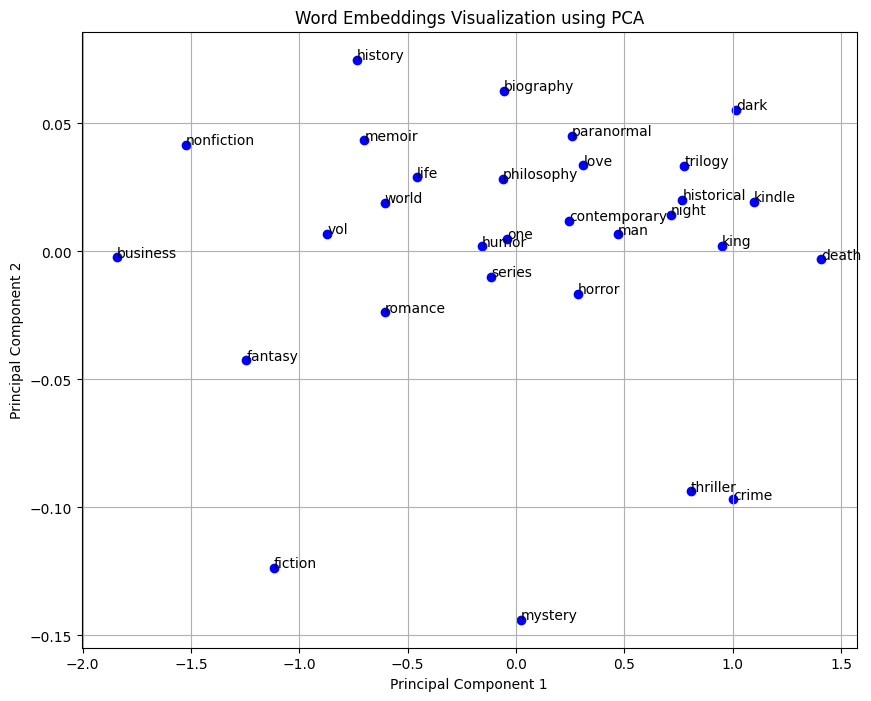

In [ ]:
# Select 30 frequent words from the vocabulary
words = list(model.wv.index_to_key)[:30]

# Get the word embeddings for these words
word_vectors = [model.wv[word] for word in words]

# Use PCA to reduce the word vectors to 2 dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Display the plot
plt.title("Word Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

# Step 6: Calculating Cosine Similarity

In [ ]:
# Stack the book embeddings into a matrix
embeddings_matrix = np.vstack(books_with_tags_df['book_embedding'].values)

# Calculate cosine similarity between the book embeddings
cosine_sim = cosine_similarity(embeddings_matrix)

# Display the shape of the similarity matrix
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

Cosine similarity matrix shape: (10000, 10000)


# Step 7: Building the Recommender System

In [ ]:
# Create a mapping from book titles to indices
book_indices = pd.Series(books_with_tags_df.index, index=books_with_tags_df['title']).drop_duplicates()

# Function to recommend books based on cosine similarity
def recommend_books(title, cosine_sim=cosine_sim, df=books_with_tags_df, book_indices=book_indices, num_recommendations=10):
    # Get the index of the book that matches the title
    if title not in book_indices:
        print(f"Book '{title}' not found in the dataset.")
        return []

    idx = book_indices[title]

    # Get the pairwise similarity scores of all books with the chosen book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 'num_recommendations' most similar books
    sim_scores = sim_scores[1:num_recommendations + 1]  # Exclude the book itself

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 'num_recommendations' most similar books
    return df[['title', 'authors', 'average_rating', 'ratings_count']].iloc[book_indices]

# Example: Recommend books similar to "The Hunger Games (The Hunger Games, #1)"
recommended_books = recommend_books("The Hunger Games (The Hunger Games, #1)")
print("Recommended Books:\n", recommended_books)


Recommended Books:
                                                   title  \
19                    Mockingjay (The Hunger Games, #3)   
506   The Hunger Games Trilogy Boxset (The Hunger Ga...   
2934  Gregor and the Code of Claw (Underland Chronic...   
412                                The Three Musketeers   
1111      Anne of the Island (Anne of Green Gables, #3)   
2795                                      The Lost Wife   
1530   Gregor the Overlander (Underland Chronicles, #1)   
2418                           Of Love and Other Demons   
3633                                     Love Walked In   
4057                                       Love Anthony   

                     authors  average_rating  ratings_count  
19           Suzanne Collins        3.853131          15953  
506          Suzanne Collins        4.371503           1144  
2934         Suzanne Collins        4.172603            365  
412          Alexandre Dumas        3.994121           3062  
1111         L.M. Mo

Make more visually appealing

In [ ]:
def recommend_books(title, cosine_sim=cosine_sim, df=books_with_tags_df, book_indices=book_indices, num_recommendations=10):
    # Check if the title exists in the dataset
    if title not in book_indices:
        print(f"Book '{title}' not found in the dataset.")
        return []

    # Get the index of the selected book
    idx = book_indices[title]

    # Get the pairwise similarity scores of all books with the selected book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top `num_recommendations` most similar books (excluding the book itself)
    sim_scores = sim_scores[1:num_recommendations + 1]
    book_indices = [i[0] for i in sim_scores]

    # Fetch the details of the recommended books
    recommendations = df[['title', 'authors', 'average_rating', 'ratings_count']].iloc[book_indices]

    # Display the selected book and its recommendations in a visually appealing way
    print(f"\nBooks similar to '{title}':\n")
    print(f"{'Title':<60} {'Author':<30} {'Avg Rating':<10} {'Ratings Count'}")
    print("=" * 100)
    for i, row in recommendations.iterrows():
        print(f"{row['title']:<60} {row['authors']:<30} {row['average_rating']:<10.2f} {row['ratings_count']}")
    print("=" * 100)

# Example: Get recommendations for a specific book title
recommend_books("The Hunger Games (The Hunger Games, #1)")



Books similar to 'The Hunger Games (The Hunger Games, #1)':

Title                                                        Author                         Avg Rating Ratings Count
Mockingjay (The Hunger Games, #3)                            Suzanne Collins                3.85       15953
The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)     Suzanne Collins                4.37       1144
Gregor and the Code of Claw (Underland Chronicles, #5)       Suzanne Collins                4.17       365
The Three Musketeers                                         Alexandre Dumas                3.99       3062
Anne of the Island (Anne of Green Gables, #3)                L.M. Montgomery                4.17       1209
The Lost Wife                                                Alyson Richman                 4.11       425
Gregor the Overlander (Underland Chronicles, #1)             Suzanne Collins                3.90       776
Of Love and Other Demons                                     Gabrie